In [ ]:
pip install networkx matplotlib

In [ ]:
!pip install scipy

In [1]:
import xpress as xp
import pandas as pd
import math
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Transform Data Pool into Compatability Graph

1. Read Excel file, turn into dataframe
2. Turn into Graph using NetworkX
3. Get list of pairs and NDDs
4. Turn edges into dictionary with weights
5. Find cycles
6. Turn list of cycles into dictionary
7. Find weights of cycles using the edge dictionary

In [2]:
# Read the Excel file, turn into dataframe
pool = pd.read_excel('SampleData.xlsx', engine='openpyxl')

# Remove unnecessary coloumns
df = pool.drop(['source','dage'], axis=1)

print(df)

     donor_id  recipient  score  altruistic
0           0        NaN    NaN         NaN
1           1        0.0   22.0         NaN
2           1        7.0   86.0         NaN
3           1        9.0   76.0         NaN
4           1       12.0   17.0         NaN
..        ...        ...    ...         ...
257        63       29.0   45.0         1.0
258        63       38.0   53.0         1.0
259        63       39.0   72.0         1.0
260        63       43.0   76.0         1.0
261        63       55.0   37.0         1.0

[262 rows x 4 columns]


In [12]:
def compatibility_network(df):
    G = nx.DiGraph() 

    if isinstance(df, list):
        pool = pd.DataFrame(df)  
    else:
        pool = df.copy()
    
    # Convert to numeric and handle NaN
    pool['donor_id'] = pd.to_numeric(pool['donor_id'], errors='coerce')
    pool['recipient'] = pd.to_numeric(pool['recipient'], errors='coerce')
    pool['score'] = pd.to_numeric(pool['score'], errors='coerce')

    # Create a list where each donor_id maps to a list of recipients
    matches = []
    for _, row in pool.iterrows():
        source = row['donor_id']
        recipient = row['recipient']
        score = row['score']

        # Ensure valid donor & recipient
        if not np.isnan(source) and not np.isnan(recipient):  
            matches.append((source, recipient, score))
    
    # Add nodes and edges to the graph
    for source, recipient, score in matches:
        G.add_node(source)
        G.add_node(recipient)
        G.add_edge(source, recipient, score=score)
    
    # Draw the graph
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G, k=0.208, seed=42) 
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='black', 
            node_size=200, font_size=5, font_weight='bold', arrows=True)

    # Add weights as labels
    edge_labels = {(source, recipient): f"{score:.1f}" for source, recipient, score in matches}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, font_color='red')
    
    plt.title("Compatibility Network")
    plt.show()

    return G

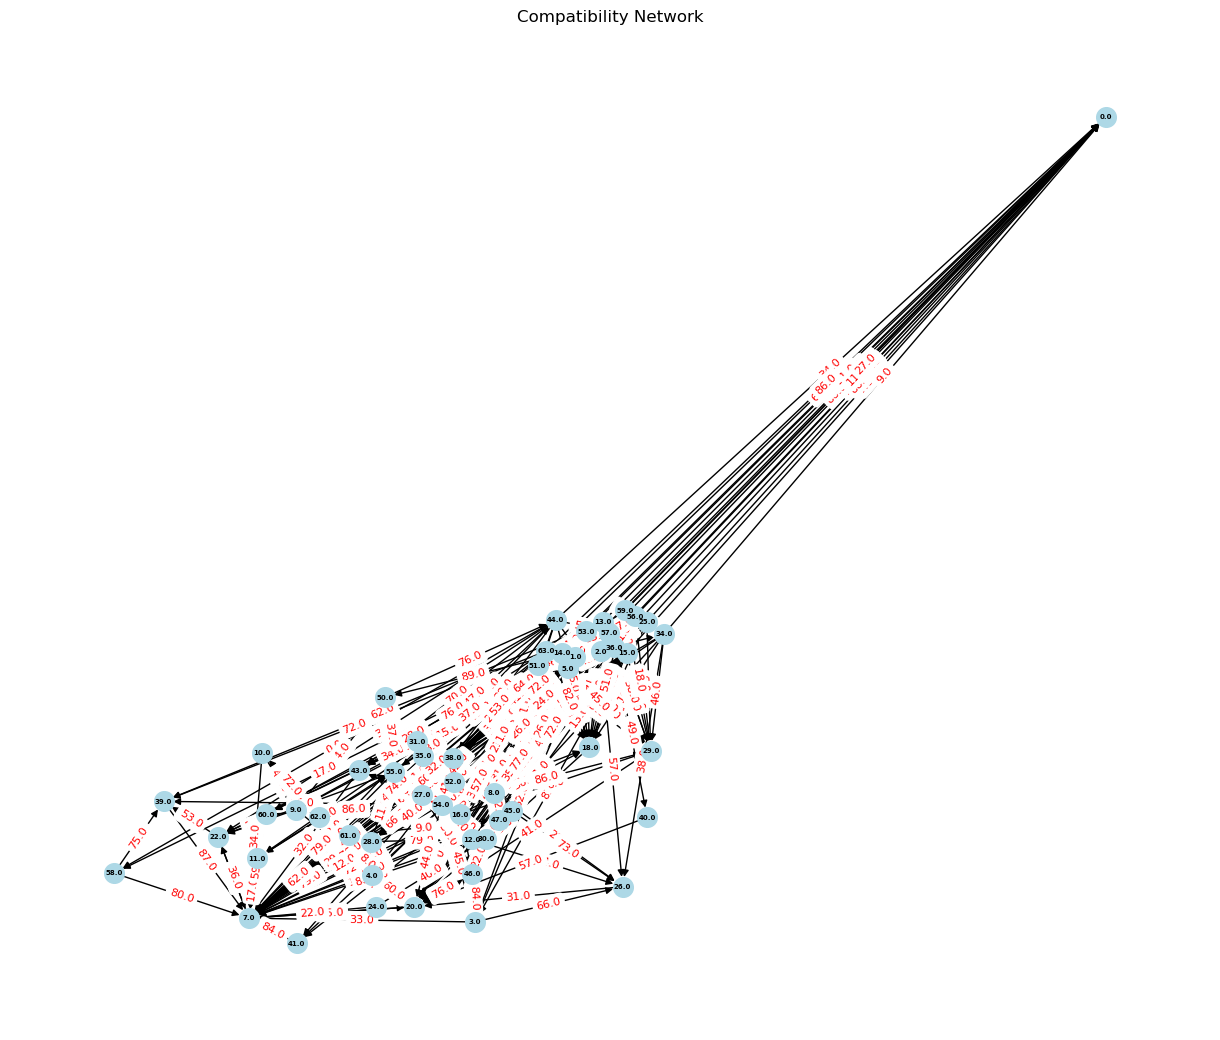

In [13]:
G = compatibility_network(df)

In [18]:
# Create list of donor pairs
# Has objective value 1947.0
pairs = list(set(df.loc[pd.isna(df['altruistic']), 'donor_id'].tolist()))

# Create list of altruistic donors
altruistic_donors = list(set(df.loc[df['altruistic'] == 1.0, 'donor_id'].tolist()))

# Create list of nodes
nodes = pairs + altruistic_donors

In [14]:
# Transform into dictionary the way Fahad had set up his model
edges = df.dropna(subset=['score']).set_index(['donor_id', 'recipient'])['score'].to_dict()

print(edges)

{(1, 0.0): 22.0, (1, 7.0): 86.0, (1, 9.0): 76.0, (1, 12.0): 17.0, (1, 18.0): 85.0, (1, 20.0): 30.0, (1, 22.0): 89.0, (1, 29.0): 24.0, (1, 34.0): 69.0, (1, 46.0): 43.0, (1, 51.0): 46.0, (2, 0.0): 79.0, (2, 4.0): 17.0, (2, 7.0): 54.0, (2, 9.0): 15.0, (2, 20.0): 44.0, (2, 25.0): 69.0, (2, 26.0): 57.0, (2, 36.0): 89.0, (2, 38.0): 11.0, (2, 51.0): 15.0, (3, 7.0): 33.0, (3, 26.0): 66.0, (4, 20.0): 60.0, (5, 0.0): 86.0, (5, 3.0): 62.0, (5, 7.0): 63.0, (5, 8.0): 17.0, (5, 18.0): 11.0, (5, 20.0): 44.0, (5, 22.0): 34.0, (5, 29.0): 74.0, (5, 38.0): 48.0, (5, 45.0): 4.0, (5, 53.0): 33.0, (5, 60.0): 14.0, (7, 20.0): 57.0, (7, 22.0): 64.0, (8, 7.0): 52.0, (8, 26.0): 23.0, (8, 31.0): 38.0, (8, 47.0): 52.0, (8, 57.0): 67.0, (9, 20.0): 83.0, (9, 22.0): 20.0, (10, 7.0): 34.0, (10, 9.0): 46.0, (11, 7.0): 17.0, (11, 55.0): 36.0, (12, 7.0): 10.0, (12, 26.0): 24.0, (12, 54.0): 25.0, (13, 0.0): 81.0, (13, 3.0): 71.0, (13, 5.0): 87.0, (13, 18.0): 70.0, (13, 20.0): 82.0, (13, 38.0): 55.0, (13, 39.0): 62.0, (13

In [15]:
cycles = sorted(nx.simple_cycles(G, length_bound=4))

# Very particular output to make sure we can turn it into a dictionary
with open("output.txt", "w") as f: 
    for cycle in cycles:
        print(",".join(map(str, cycle)), file=f)

In [16]:
# Read the file and convert each line into a tuple
with open("output.txt", "r") as f:
    cycles = [tuple(map(float, line.strip().split(","))) for line in f if line.strip()]

# Convert list of tuples into a dictionary
cycles_dict = {i: cycle for i, cycle in enumerate(cycles)}
print(cycles_dict)

{0: (1.0, 51.0, 16.0, 43.0), 1: (2.0, 36.0, 5.0, 53.0), 2: (2.0, 36.0, 53.0), 3: (3.0, 7.0, 20.0, 46.0), 4: (3.0, 26.0, 20.0, 46.0), 5: (5.0, 8.0, 57.0, 53.0), 6: (5.0, 38.0, 56.0, 36.0), 7: (5.0, 53.0), 8: (5.0, 53.0, 36.0), 9: (7.0, 20.0), 10: (7.0, 20.0, 46.0, 35.0), 11: (7.0, 22.0), 12: (7.0, 22.0, 39.0), 13: (7.0, 22.0, 55.0), 14: (7.0, 22.0, 55.0, 30.0), 15: (11.0, 55.0, 44.0, 57.0), 16: (12.0, 54.0), 17: (20.0, 46.0), 18: (20.0, 46.0, 35.0, 51.0), 19: (22.0, 55.0, 44.0), 20: (34.0, 38.0, 56.0, 25.0), 21: (35.0, 30.0, 46.0), 22: (35.0, 44.0, 30.0, 46.0), 23: (35.0, 51.0), 24: (36.0, 31.0, 57.0, 53.0), 25: (36.0, 31.0, 57.0, 56.0), 26: (36.0, 51.0, 38.0, 56.0), 27: (36.0, 53.0), 28: (36.0, 53.0, 38.0, 56.0), 29: (36.0, 56.0), 30: (38.0, 56.0), 31: (38.0, 56.0, 25.0), 32: (38.0, 56.0, 59.0), 33: (56.0, 52.0)}


In [17]:
# Function to calculate the sum of weights for a given cycle
def get_cycle_weight(cycle, edges):
    total_weight = 0
    for i in range(len(cycle) - 1):
        edge = (cycle[i], cycle[i + 1])
        if edge in edges:
            total_weight += edges[edge]
        
    # Add the weight for the edge from the last node to the first node
    closing_edge = (cycle[-1], cycle[0])
    if closing_edge in edges:
        total_weight += edges[closing_edge]
        
    return total_weight

# Create dictionary with cycles and weights
cycles_with_weights = {
    tuple(cycle): get_cycle_weight(cycle, edges)
    for cycle in cycles_dict.values()
}

print(cycles_with_weights)

{(1.0, 51.0, 16.0, 43.0): 145.0, (2.0, 36.0, 5.0, 53.0): 168.0, (2.0, 36.0, 53.0): 107.0, (3.0, 7.0, 20.0, 46.0): 234.0, (3.0, 26.0, 20.0, 46.0): 241.0, (5.0, 8.0, 57.0, 53.0): 157.0, (5.0, 38.0, 56.0, 36.0): 132.0, (5.0, 53.0): 35.0, (5.0, 53.0, 36.0): 132.0, (7.0, 20.0): 72.0, (7.0, 20.0, 46.0, 35.0): 274.0, (7.0, 22.0): 100.0, (7.0, 22.0, 39.0): 204.0, (7.0, 22.0, 55.0): 189.0, (7.0, 22.0, 55.0, 30.0): 217.0, (11.0, 55.0, 44.0, 57.0): 91.0, (12.0, 54.0): 38.0, (20.0, 46.0): 136.0, (20.0, 46.0, 35.0, 51.0): 209.0, (22.0, 55.0, 44.0): 130.0, (34.0, 38.0, 56.0, 25.0): 182.0, (35.0, 30.0, 46.0): 160.0, (35.0, 44.0, 30.0, 46.0): 216.0, (35.0, 51.0): 102.0, (36.0, 31.0, 57.0, 53.0): 197.0, (36.0, 31.0, 57.0, 56.0): 128.0, (36.0, 51.0, 38.0, 56.0): 106.0, (36.0, 53.0): 71.0, (36.0, 53.0, 38.0, 56.0): 97.0, (36.0, 56.0): 66.0, (38.0, 56.0): 126.0, (38.0, 56.0, 25.0): 129.0, (38.0, 56.0, 59.0): 178.0, (56.0, 52.0): 108.0}


# Code to turn the edge dictionary into a dataframe so we can graph it (NOT NEEDED)

In [34]:
# Convert to DataFrame
data = pd.DataFrame(list(dictionary.items()), columns=['pair', 'score'])

# Split 'pair' tuple into two separate columns
data[['source', 'recipient']] = pd.DataFrame(data['pair'].tolist(), index=df.index)

# Drop the original 'pair' column
data = data.drop(columns=['pair'])

# Reorder columns
data = data[['source', 'recipient', 'score']]

print(data)

     source  recipient  score
0       0.0        NaN    NaN
1       1.0        0.0   22.0
2       1.0        7.0   86.0
3       1.0        9.0   76.0
4       1.0       12.0   17.0
..      ...        ...    ...
257     NaN       29.0   45.0
258     NaN       38.0   53.0
259     NaN       39.0   72.0
260     NaN       43.0   76.0
261     NaN       55.0   37.0

[262 rows x 3 columns]


# Ignore! Attempt at cycle detection and extra code that is not used now but maybe used later

In [71]:
allarcs = list(dictionary.keys())
arcs = [a for a in arcs if not math.isnan(a[0]) and not math.isnan(a[1])]
donors = df['donor_id'].to_list()
nodes = list(set(donors))
print(nodes)

[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 20, 22, 24, 25, 26, 27, 28, 29, 30, 31, 34, 35, 36, 38, 39, 40, 41, 43, 44, 45, 46, 47, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]


In [78]:
# Initialize the graph
graph = defaultdict(list)
for u, v in arcs:
    graph[u].append(v)
    graph[v].append(u)

visited = set()
cycles = []

def dfs(node, parent, path):
    # Mark the current node as visited
    visited.add(node)
    path.append(node)
    
    # Explore neighbors
    for neighbor in graph[node]:
        # If the neighbor hasn't been visited, recurse into it
        if neighbor not in visited:
            dfs(neighbor, node, path)
        # If the neighbor is visited and is not the parent, we've found a cycle
        elif neighbor != parent:
            # We found a cycle, extract the cycle path
            if neighbor in path:  # Ensure the neighbor is in the current path
                cycle_index = path.index(neighbor)
                cycle = path[cycle_index:]  # Extract the cycle from the path

                if len(cycle) < 5:
                    cycles.append(cycle)
    
    # Backtrack from the current node
    path.pop()

# For every node, perform DFS if it hasn't been visited yet
for node in nodes:
    if node not in visited:
        dfs(node, None, [])

# Print all detected cycles
if cycles:
    for cycle in cycles:
        print("Cycle:", cycle)
else:
    print("No cycles detected.")


Cycle: [0, 1.0, 7.0, 2.0]
Cycle: [2.0, 4.0, 20.0]
Cycle: [5.0, 3.0, 26.0, 8.0]
Cycle: [15.0, 29.0, 16.0]
Cycle: [15.0, 29.0, 16.0, 38.0]
Cycle: [29.0, 16.0, 38.0, 25.0]
Cycle: [38.0, 25.0, 34.0]
Cycle: [35.0, 30.0, 46.0]
Cycle: [44.0, 35.0, 30.0]
Cycle: [22.0, 9.0, 50.0, 44.0]
Cycle: [55.0, 22.0, 9.0, 50.0]
Cycle: [38.0, 25.0, 56.0]
Cycle: [38.0, 25.0, 56.0]
Cycle: [54.0, 15.0, 29.0]
Cycle: [51.0, 13.0, 18.0]
Cycle: [20.0, 5.0, 3.0, 26.0]
Cycle: [7.0, 2.0, 4.0, 20.0]
Cycle: [7.0, 2.0, 4.0, 20.0]
